# Imports (as Obtain)

In [1]:
import os
import pandas as pd
import numpy as np

from PIL import Image

In [116]:
# set paths
#path = '/Users/eannefawcett/Desktop/Data Science/Projects/cross-stitch-patternizer/' # pc
path = '/Users/student/Desktop/Data Science/Projects/cross-stitch-patternizer/' # mac
#data_path = '/Users/eannefawcett/Desktop/Data Science/Projects/data/cross-stitch-patternizer/' # pc
data_path = '/Users/student/Desktop/Data Science/Projects/data/cross-stitch-patternizer/' # mac
raw_path = data_path + 'raw/'
interim_path = data_path + 'interim/'
processed_path = data_path + 'processed/'
print(path)
print(data_path)
print(raw_path)
print(interim_path)
print(processed_path)

/Users/student/Desktop/Data Science/Projects/cross-stitch-patternizer/
/Users/student/Desktop/Data Science/Projects/data/cross-stitch-patternizer/
/Users/student/Desktop/Data Science/Projects/data/cross-stitch-patternizer/raw/
/Users/student/Desktop/Data Science/Projects/data/cross-stitch-patternizer/interim/
/Users/student/Desktop/Data Science/Projects/data/cross-stitch-patternizer/processed/


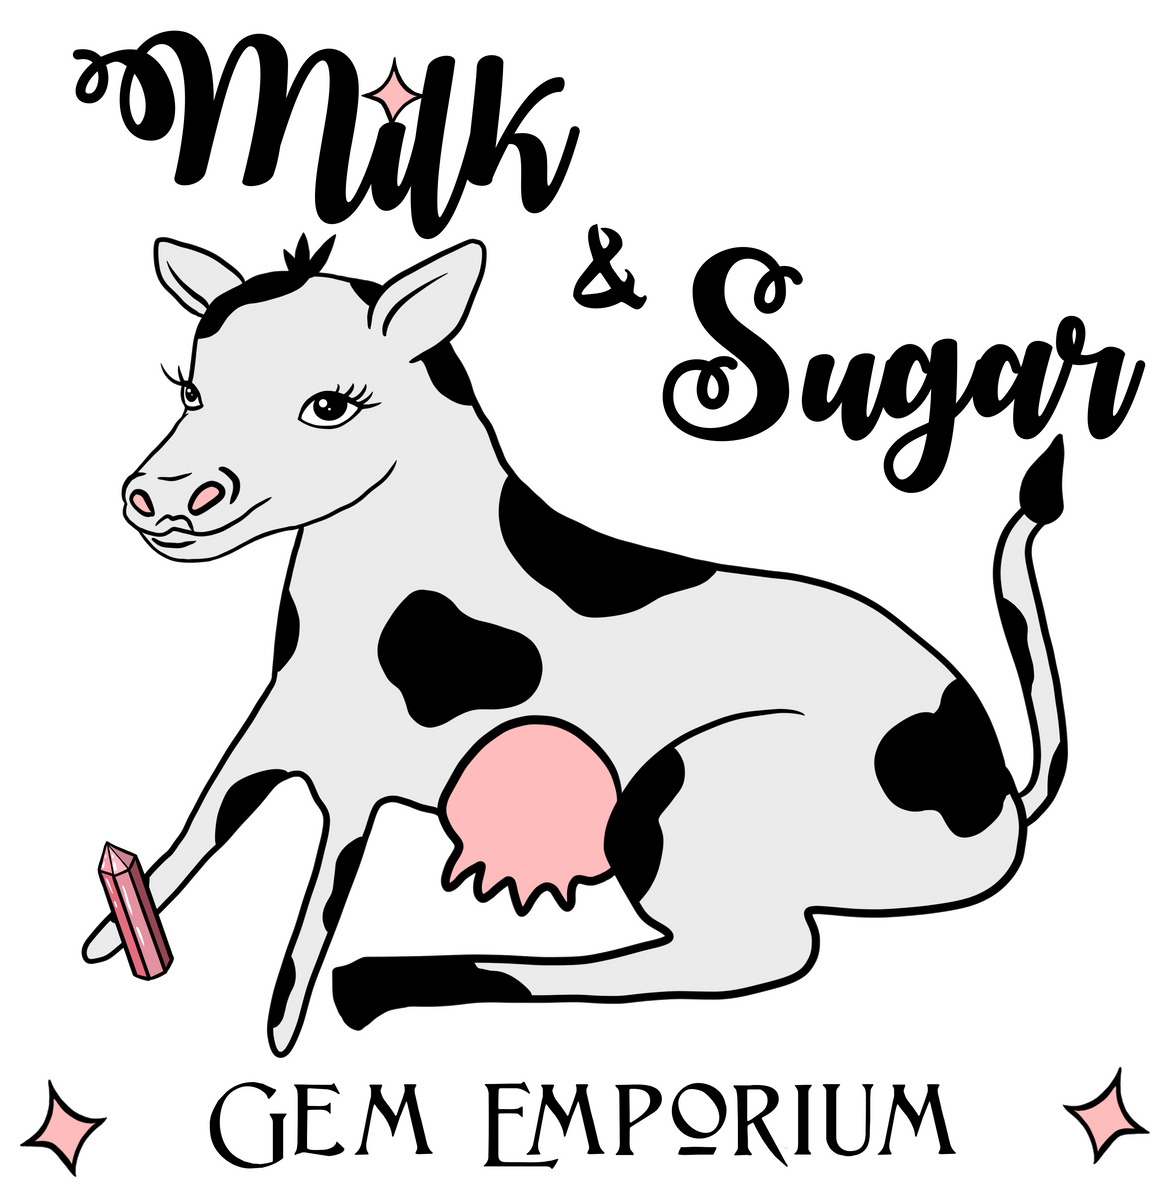

In [117]:
os.chdir(raw_path) # mac laptop
msge_im = Image.open('milk_and_sugar_gem_emporium.png')
msge_im

# Methodology (as Scrub)

### Preprocessing

In [13]:
# check metadata, if something is present, procede with next cell
msge_im.info

{'icc_profile': b'\x00\x00\x01\xa8lcms\x02\x10\x00\x00mntrRGB XYZ \x07\xdc\x00\x01\x00\x19\x00\x03\x00)\x009acspAPPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-lcms\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00_cprt\x00\x00\x01L\x00\x00\x00\x0cwtpt\x00\x00\x01X\x00\x00\x00\x14rXYZ\x00\x00\x01l\x00\x00\x00\x14gXYZ\x00\x00\x01\x80\x00\x00\x00\x14bXYZ\x00\x00\x01\x94\x00\x00\x00\x14rTRC\x00\x00\x01\x0c\x00\x00\x00@gTRC\x00\x00\x01\x0c\x00\x00\x00@bTRC\x00\x00\x01\x0c\x00\x00\x00@desc\x00\x00\x00\x00\x00\x00\x00\x05c2ci\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00curv\x00\x00\x00\x00\x00\x00\x00\x1a\x00\x00\x00\xcb\x01\xc9\x03c\x05\x92\x08k\x0b\xf6\x10?\x15Q\x1b4!\xf1)\x902\x18;\x92F\x05Qw]\xedkpz\x05\x89\xb1\x9a|\xaci

In [96]:
# png metadata, including licensing information
import io
from PIL import ImageCms
icc = msge_im.info.get('icc_profile')
f = io.BytesIO(icc)
prf = ImageCms.ImageCmsProfile(f)
copyright_info = ImageCms.getProfileCopyright(prf) # cc0 means creative commons no licensing
profile_description = ImageCms.getProfileDescription(prf) #c2ci means an updated facebook profile picture
profile_info = ImageCms.getProfileInfo(prf) #c2ci and cc0
profile_manufacturer = ImageCms.getProfileManufacturer(prf) #none
profile_model = ImageCms.getProfileModel(prf) #none
profile_name = ImageCms.getProfileName(prf) #c2ci
#ImageCms.isIntentSupported(prf) #need to intent and direction, check compatibility to pdf later on maybe?
#ImageCms.profileToProfile(prf) #need to intent and direction, check compatibility to pdf later on maybe?
dpi = msge_im.info.get('dpi')
print('License: ', copyright_info.rstrip())
print('Type of image: ', profile_description.rstrip())
print('Image info overview: ', [x for x in profile_info.split()])
print('Manufacturer (if any): ', profile_manufacturer.rstrip())
print('Model (idk): ', profile_model.rstrip())
print('Image classificaiton: ', profile_name.rstrip())
print('DPI: ', dpi)

License:  CC0
Type of image:  c2ci
Image info overview:  ['c2ci', 'CC0']
Manufacturer (if any):  
Model (idk):  
Image classificaiton:  c2ci
DPI:  (132, 132)


## Center Image

So, first things first, an end user will be putting aida fabric into a circular hoop to create their cross stitch. Most will desire that their image will be centered, so that's our first order of operation here, to center the image, or rather find it's center. 

In [3]:
msge_im.size

(1171, 1200)

While, I could take this size and divide by two to find the mathematical center of the image, that's not really what art composition is about. Instead I would argue, and was advised, that finding the center of where all of the color would be in a cross stitch is more advantageous, because surrounding white space or padding can be added in later. So I decided to go with a "center of mass" approach for color using a probability distribution and summation technique.

In [4]:
def find_center(pil_image):
    '''This function finds the center of mass for a user provided image,
       and returns the pixels in the x and y directions that
       have been adjusted for aida counts that are always even.
       Used the answer provided by https://stackoverflow.com/users/5288583/martin-stancsics at
       https://stackoverflow.com/questions/37519238/python-find-center-of-object-in-an-image
       to develop the center of mass equations.
       '''
    
    # get original size
    (X, Y) = pil_image.size
    m = np.zeros((X, Y))

    # account for white vs non-white
    m = np.sum(np.asarray(pil_image), -1) < 255*3
    m = m / np.sum(np.sum(m))

    # marginal distributions
    dx = np.sum(m, 0)
    dy = np.sum(m, 1)

    # expected values
    cx = np.sum(dx * np.arange(X))
    cy = np.sum(dy * np.arange(Y))

    # ensure that each returned expected value 
    # will result in an even number 
    # for aida thread count standards
    if round(cx)%2 != 0:
        adj_cx = round(cx) + 1
    else:
        adj_cx = round(cx)
    if round(cy)%2 != 0:
        adj_cy = round(cy) + 1
    else:
        adj_cy = round(cy)
    
    return adj_cx, adj_cy

In [5]:
x_center, y_center = find_center(msge_im)
x_center, y_center

(572, 582)

## Color Matching

The next problem a cross stitcher faces is color matching. This next section of code will address color matching.

### Alpha Layers

Some input images will be in the standard RGB format, but some might have an alpha layer, as this image does. That alpha layer will need to be integrated into the final image, as cross stitching is one flat layer instead of a composite of many layers as is often the case with digital images.

In [6]:
# check for the different bands of data stored in the image
msge_im_bands = msge_im.getbands()
msge_im_bands

('R', 'G', 'B', 'A')


4

In [15]:
# check for type and depth for each pixel
msge_im.mode

'RGBA'

In [120]:
# remove transparency, inspired by https://github.com/zeantsoi/remove-transparency
if msge_im.mode == 'RGBA':
    # Create a blank background image
    bg = Image.new('RGB', msge_im.size, (255, 255, 255))
    # Paste image to background image
    bg.paste(msge_im, (0, 0), msge_im)
    # Save pasted image as image
    bg.save(interim_path + 'milk_and_sugar_gem_emporium_flat.png', "PNG")
    msge_flat = Image.open(interim_path + 'milk_and_sugar_gem_emporium_flat.png')
else:
    msge_flat = msge_im
msge_flat.mode

'RGB'

In [124]:
msge_flat_bands = msge_flat.getbands()
msge_flat_bands

('R', 'G', 'B')

In [125]:
msge_flat_mode = msge_flat.mode
msge_flat_mode

'RGB'

### Present Colors in RGB Format

In [126]:
msge_flat_colors = msge_flat.getcolors()
print(msge_im_colors)

None


In [148]:
import random

In [149]:
msge_color_data = list(msge_flat.getdata())
random.sample(msge_color_data, 10)

[(255, 255, 255),
 (255, 255, 255),
 (255, 255, 255),
 (0, 0, 0),
 (235, 235, 235),
 (235, 235, 235),
 (0, 0, 0),
 (255, 255, 255),
 (255, 255, 255),
 (255, 255, 255)]

In [151]:
msge_flat_palette = msge_flat.getpalette()
print(msge_flat_palette)

None


#### Visualization for RGB Format

In [129]:
msge_flat_r, msge_flat_g, msge_flat_b = msge_flat.split()

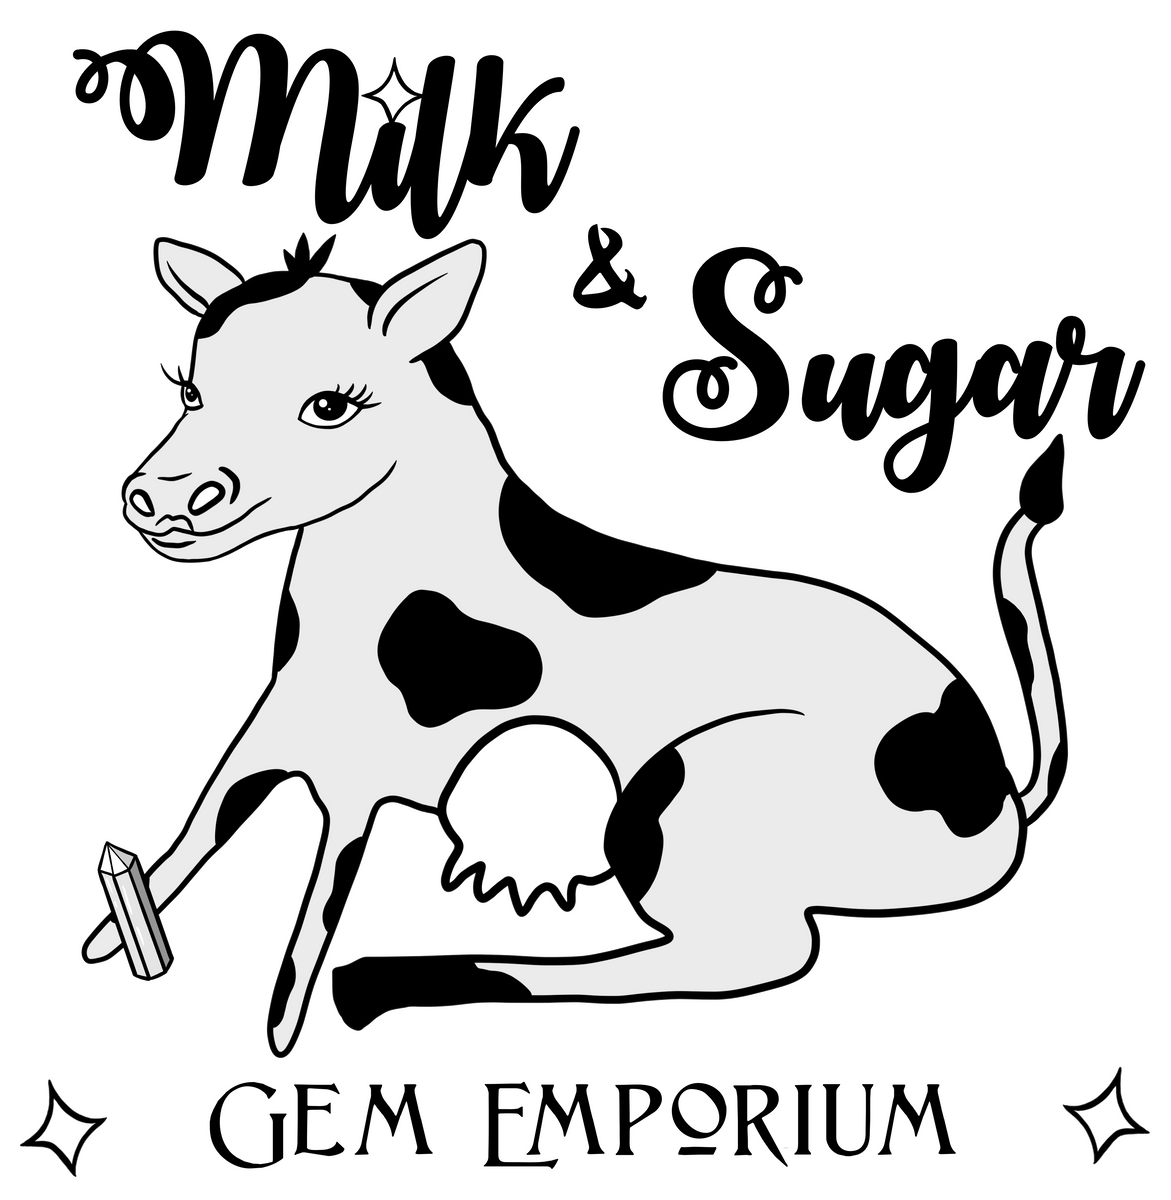

In [130]:
msge_flat_r

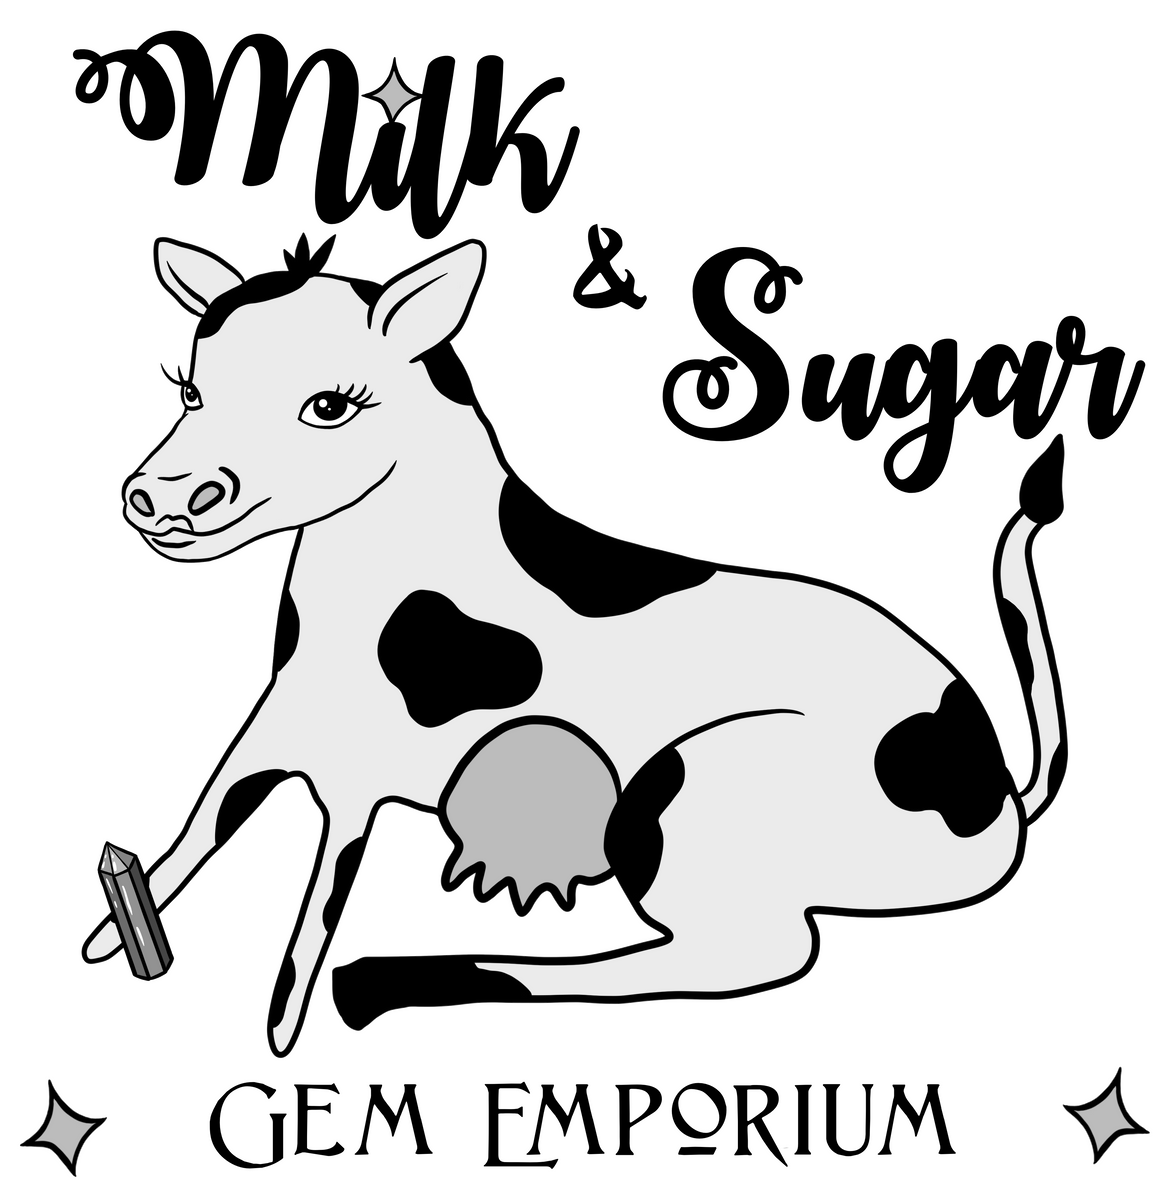

In [131]:
msge_flat_g

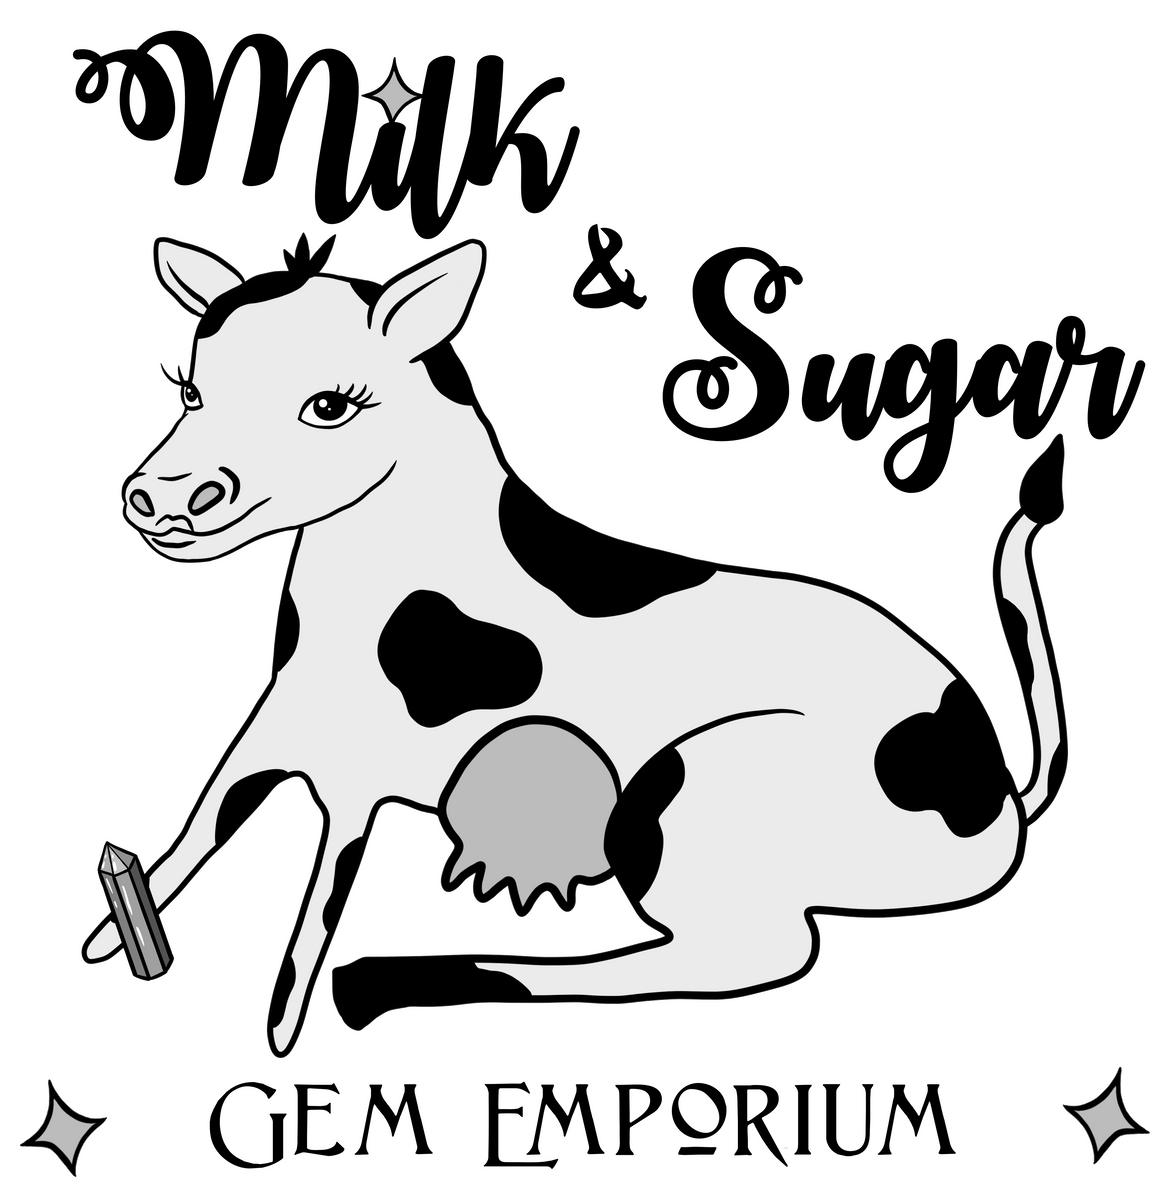

In [132]:
msge_flat_b

## Adjustments for Aida Count

## Dimensions of Project